## I. Pen-and-Paper

In [6]:
from scipy.stats import multivariate_normal
import numpy as np

def print_vector(vector):
    for value in vector:
        print(f"{value:.3f}")

def print_table(data):
    for row in data:
        formatted_row = [f"{value:.3f}" for value in row]  # Adjust width as necessary
        print("\t".join(formatted_row))

epochs = 3

x = [[1, 0], [0, 2], [3, -1]]

u = [[2, -1], [1, 1]]
sigma = [[[4, 1], [1, 4]], [[2, 0], [0, 2]]]
pi = [0.5, 0.5]

for count in range(epochs):

    print(f"\n-------------- Epoch {count + 1}/{epochs} --------------\n")

    tab1 = [[0 for _ in range(len(x))] for _ in range(len(u))]
    for k in range(len(u)):
        for i in range(len(x)):
            tab1[k][i] = multivariate_normal(u[k], sigma[k]).pdf(x[i]) * pi[k]
    print("p(ck, xi)")
    print_table(tab1)
    print()
    
    tab2 = [[0 for _ in range(len(x))] for _ in range(len(u))]
    for i in range(len(x)):
        sum = 0
        for j in range(len(u)):
            sum += tab1[j][i]
        for k in range(len(u)):
            tab2[k][i] = tab1[k][i] / sum
    print("p(ck | xi)")
    print_table(tab2)
    print()
    
    N = [0 for _ in range(len(u))]
    for k in range(len(u)):
        N[k] = 0
        for i in range(len(x)):
            N[k] += tab2[k][i]
        print(f"N{k + 1} = {N[k]:.3f}")
    print()    
    
    for k in range(len(u)):
        u[k] = [0, 0]
        for i in range(len(x)):
            u[k][0] += tab2[k][i] * x[i][0]
            u[k][1] += tab2[k][i] * x[i][1]
        u[k][0] /= N[k]
        u[k][1] /= N[k]
        print(f"u{k + 1}")
        print_vector(u[k])
    print()
    
    for k in range(len(u)):
        sum = np.array([[0 for _ in range(len(u))] for _ in range(len(u))])
        for i in range(len(x)):
            sum = sum + tab2[k][i] * np.outer(np.array(x[i]) - np.array(u[k]), np.array(x[i]) - np.array(u[k]))
        sum /= N[k]
        sigma[k] = sum.tolist()
        print(f"sigma{k + 1}")
        print_table(sigma[k])
    print()
    
    sumN = 0
    for k in range(len(u)):
        sumN += N[k]
    
    for k in range(len(u)):
        pi[k] = N[k] / sumN
    print(f"pi{k + 1}")
    print_vector(pi)


-------------- Epoch 1/3 --------------

p(ck, xi)
0.015	0.002	0.018
0.031	0.024	0.005

p(ck | xi)
0.322	0.092	0.770
0.678	0.908	0.230

N1 = 1.183
N2 = 1.817

u1
2.223
-0.496
u2
0.754
0.873

sigma1
1.182	-0.849
-0.849	0.714
sigma2
0.947	-1.039
-1.039	1.364

pi2
0.394
0.606

-------------- Epoch 2/3 --------------

p(ck, xi)
0.047	0.000	0.137
0.090	0.127	0.007

p(ck | xi)
0.342	0.004	0.953
0.658	0.996	0.047

N1 = 1.299
N2 = 1.701

u1
2.465
-0.728
u2
0.469
1.144

sigma1
0.793	-0.407
-0.407	0.215
sigma2
0.414	-0.619
-0.619	1.061

pi2
0.433
0.567

-------------- Epoch 3/3 --------------

p(ck, xi)
0.244	0.000	0.824
0.173	0.268	0.000

p(ck | xi)
0.586	0.000	1.000
0.414	1.000	0.000

N1 = 1.586
N2 = 1.414

u1
2.261
-0.631
u2
0.293
1.414

sigma1
0.932	-0.466
-0.466	0.233
sigma2
0.207	-0.414
-0.414	0.828

pi2
0.529
0.471


## II. Programming and critical analysis

#### 1. a)

In [15]:
import pandas as pd

dataset = pd.read_csv("accounts.csv")
X = dataset.drop('deposit', axis=1)
X = X.iloc[:, :8] # select the first 8 features
X = X.drop_duplicates() # remove duplicates
X_notDummy = X.dropna() #  remove null values
X = pd.get_dummies(X_notDummy, drop_first=True) # change the feature type
X.head()

age  balance  job_blue-collar  job_entrepreneur  job_housemaid  \
0   59     2343            False             False          False   
1   56       45            False             False          False   
2   41     1270            False             False          False   
3   55     2476            False             False          False   
4   54      184            False             False          False   

   job_management  job_retired  job_self-employed  job_services  job_student  \
0           False        False              False         False        False   
1           False        False              False         False        False   
2           False        False              False         False        False   
3           False        False              False          True        False   
4           False        False              False         False        False   

   ...  job_unemployed  job_unknown  marital_married  marital_single  \
0  ...           False        False             True           False   
1  ...           False        False             True           False   
2  ...           False        False             True           False   
3  ...           False        False             True           False   
4  ...           False        False             True           False   

   education_secondary  education_tertiary  education_unknown  default_yes  \
0                 True               False              False        False   
1                 True               False              False        False   
2                 True               False              False        False   
3                 True               False              False        False   
4                False                True              False        False   

   housing_yes  loan_yes  
0         True     False  
1        False     False  
2         True     False  
3         True     False  
4        False     False  

[5 rows x 21 columns]

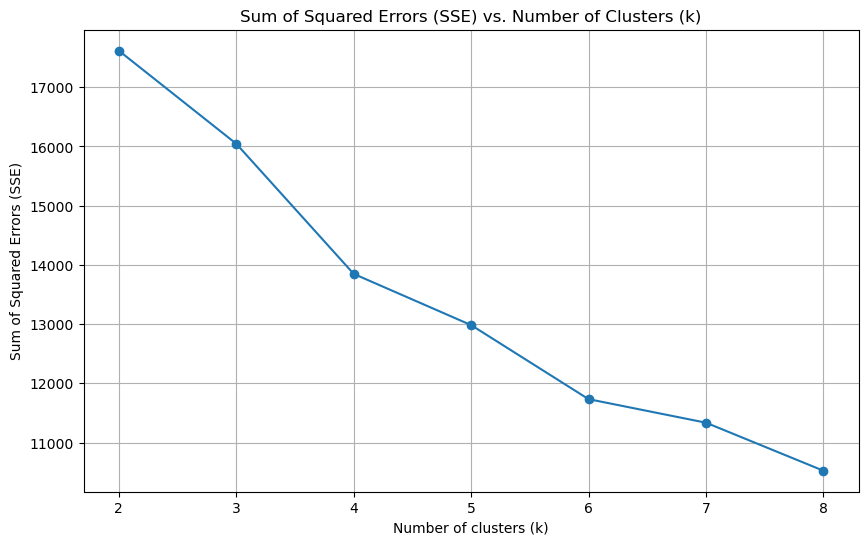

In [17]:
from sklearn import datasets, metrics, cluster, mixture
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

X_MinMaxScaled = MinMaxScaler().fit_transform(X)

sse = []
for k in range(2, 9):
    # parameterize clustering
    kmeans_algo = cluster.KMeans(n_clusters=k, max_iter=500, random_state=42)

    # learn the model
    kmeans_model = kmeans_algo.fit(X_MinMaxScaled)

    sse += [kmeans_model.inertia_]

plt.figure(figsize=(10, 6))
plt.plot(range(2, 9), sse, marker='o')
plt.title('Sum of Squared Errors (SSE) vs. Number of Clusters (k)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid()
plt.show()

#### 1. b)

O "elbow method" consiste em identificar o ponto no gráfico onde a taxa de redução do SSE desacelera significativamente. Esse ponto geralmente indica o número ideal de clusters, pois adicionar mais clusters além desse ponto traz retornos decrescentes em termos de redução do SSE.

Observando o gráfico, a queda acentuada no SSE ocorre entre 2 e 4 clusters.
Após 4 clusters, a redução no SSE se torna mais lenta, indicando que o "elbow point" parece estar em 4 clusters.

#### 1. c)

O método k-means é eficaz para dados numéricos e contínuos, pois ele minimiza a variação dentro dos clusters usando a média dos dados. No entanto, o k-modes é uma variante do k-means projetada especificamente para lidar com dados categóricos, onde os pontos de dados podem ser representados pela moda (valores mais frequentes) em vez de médias.

Se o conjunto de dados contém muitas variáveis categóricas (como ocupação, educação, ou outros atributos qualitativos), o k-modes poderia ser uma escolha melhor. Ele é mais apropriado para lidar com dados em que a média não é significativa, o que é o caso para variáveis não numéricas.

#### 2. a)

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_StandardScaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit(X_StandardScaled).transform(X_StandardScaled)
print('PCA explained variance (first two components):',pca.explained_variance_ratio_)

PCA explained variance (first two components): [0.11679017 0.11075981]


#### 2. b)

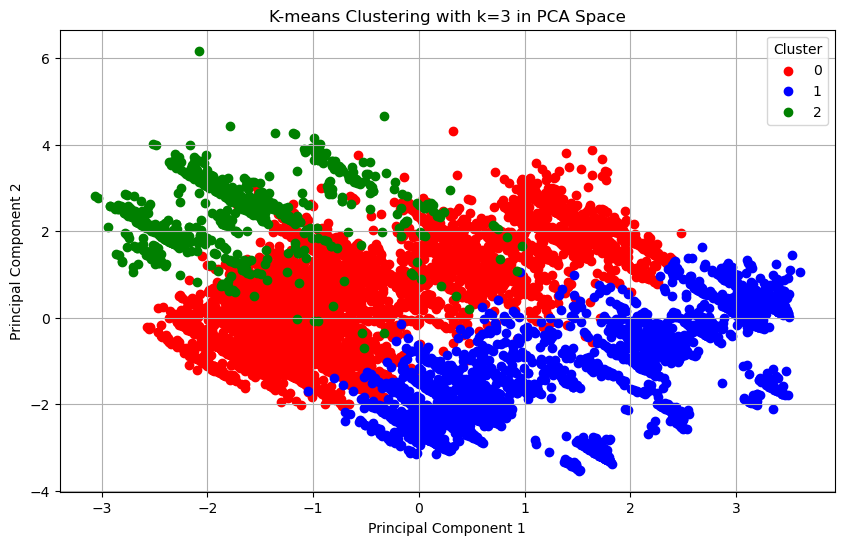

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import cluster
from matplotlib.colors import ListedColormap

# parameterize clustering
kmeans_algo = cluster.KMeans(n_clusters=3, random_state=42)

# learn the model
kmeans_model = kmeans_algo.fit(X_StandardScaled)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = kmeans_model.labels_

colors = ['red', 'blue', 'green']

plt.figure(figsize=(10, 6))
for i in range(3):
    plt.scatter(pca_df[pca_df['cluster'] == i]['PC1'], pca_df[pca_df['cluster'] == i]['PC2'], color=colors[i], label=f'{i}')

plt.title('K-means Clustering with k=3 in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.legend(title='Cluster', loc='upper right')
plt.grid()
plt.show()

Os dois primeiros componentes principais explicam apenas cerca de 11,7% e 11,1% da variância dos dados, respectivamente. Isso significa que essas componentes capturam uma pequena fração da variabilidade total dos dados, sugerindo que pode haver mais informação relevante em outras componentes principais. Em termos práticos, isso limita a capacidade de separação visual dos clusters neste gráfico.

Os clusters 0, 1 e 2 (representados por cores diferentes) apresentam uma sobreposição considerável.
Não há uma divisão nítida entre eles, indicando que os dados se distribuem de forma mista nas duas primeiras componentes principais.
Apesar de alguma separação entre as cores, especialmente entre os clusters 1 e 2, a sobreposição entre os clusters sugere que o valor de k=3 não leva a uma separação muito clara na dimensão das duas primeiras componentes principais.

Com base na baixa variância explicada pelas duas primeiras componentes principais e na considerável sobreposição entre clusters, não é possível separar claramente os clusters apenas com essas duas componentes. Isso indica que uma análise de clustering completa pode exigir mais componentes principais para uma segmentação mais precisa.








#### 2. c)

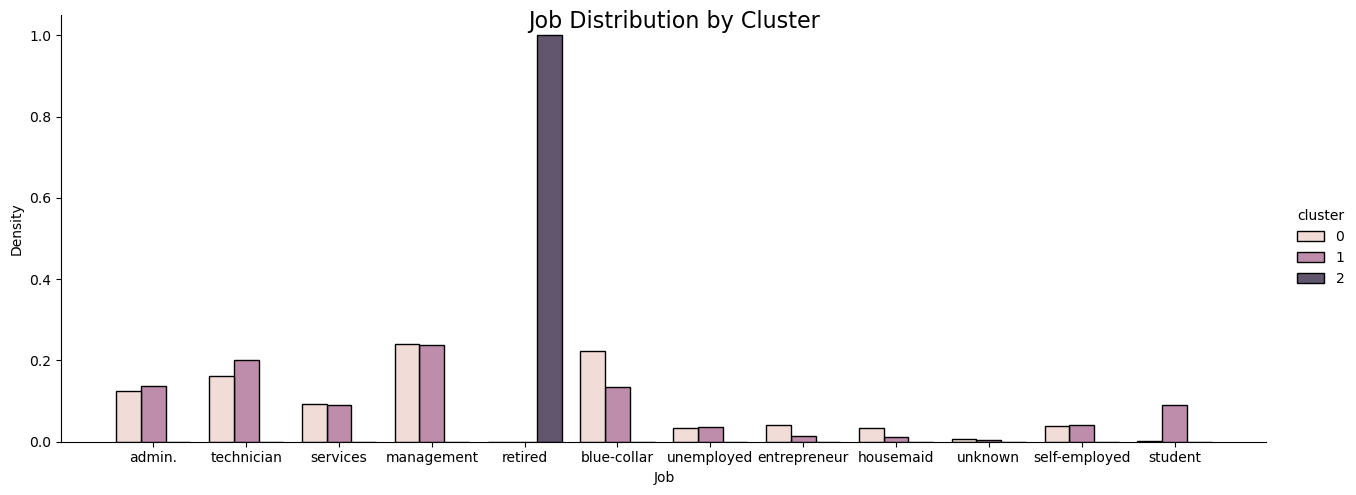

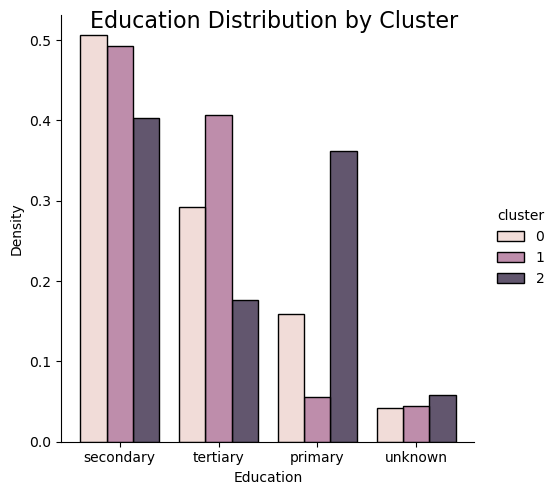

In [33]:
import seaborn as sns

X_notDummy['cluster'] = kmeans_model.labels_

g_jobs = sns.displot(X_notDummy, x='job', hue='cluster', multiple='dodge', stat='density', shrink=0.8, common_norm=False, aspect=2.6)

g_jobs.fig.suptitle('Job Distribution by Cluster', fontsize=16)
g_jobs.set_axis_labels('Job', 'Density')
g_jobs.set_titles(col_template='Cluster {col_name}')

plt.show()

g_education = sns.displot(X_notDummy, x='education', hue='cluster', multiple='dodge', stat='density', shrink=0.8, common_norm=False)

g_education.fig.suptitle('Education Distribution by Cluster', fontsize=16)
g_education.set_axis_labels('Education', 'Density')
g_education.set_titles(col_template='Cluster {col_name}')

plt.show()

Observemos o gráfico relativamente à profissão.  
O cluster 0 tem uma maior concentração de indivíduos em profissões operacionais, como "blue-collar", seguido de uma leve representação em diversas outras categorias de emprego.  
O cluster 1 apresenta uma distribuição mais variada, incluindo profissões como "admin" e "student", sugerindo que este grupo pode incluir clientes mais jovens ou em início de carreira.  
O cluster 2 tem uma proporção significativa de indivíduos reformados ("retired"), indicando que ele pode representar uma categoria demográfica mais velha ou de clientes inativos no mercado de trabalho.  

Observemos o gráfico relativamente à educação.  
O cluster 0 tem uma predominância de clientes com nível secundário de educação, o que pode indicar um perfil socioeconómico específico dentro deste grupo.  
O cluster 1 apresenta uma maior variedade, com uma proporção considerável de clientes com nível terciário de educação, o que pode indicar um grupo mais jovem e com formação mais alta, como visto para a profissão.  
O cluster 2 também possui uma representação alta de clientes com nível secundário, mas há uma presença significativa de clientes com nível primário, o que pode reforçar o perfil demográfico mais velho observado anteriormente.  